El propósito de este trabajo es entrenar un modelo de ML para intentar predecir si hubo un cambio en el estilo de vida de los encuestados en base a sus respuestas. Para esto se creará una nueva columna llamada 'lifestyle_change' y se considerá que hubo un cambio en el estilo de vida cuando alguna de las valoraciones hechas por los encuestados sea mayor a un puntaje de 0.5. Los modelos a utilizar y comparar serán Regresión Logística, Random Forest y Support Vector Machine.

# Import de bibliotecas - Carga y preparación de los datos

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/efectos_psiquicos_covid_modificado.csv')

In [ ]:
df

,age,gender,occupation,time_bp,time_dp,travel_time,easeof_online,home_env,prod_inc,sleep_bal,new_skill,fam_connect,relaxed,self_time,like_hw,dislike_hw,prefer,certaindays_hw
0,19-25,Male,Student in College,7,5,0.5,3,3,0.0,0.0,0.5,1.0,-0.5,-0.5,100,1,Physical,Yes
1,0-18,Male,Student in School,7,11,0.5,4,2,-0.5,0.5,-1.0,1.0,1.0,1.0,1111,1110,Physical,No
2,19-25,Male,Student in College,7,7,1.5,2,2,1.0,0.0,0.5,0.5,0.5,0.5,1100,111,Physical,Yes
3,19-25,Male,Student in College,7,7,1.5,3,1,0.0,1.0,0.5,0.0,-1.0,-0.5,100,1111,Physical,Yes
4,19-25,Female,Student in College,7,7,1.5,2,2,0.0,0.0,0.0,0.0,0.5,0.0,1010,1000,Physical,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1170,40-50,Female,Entrepreneur,9,9,0.5,2,1,0.5,-0.5,-0.5,0.5,0.0,0.0,10,1,Physical,Yes
1171,26-32,Female,Homemaker,5,12,0.5,3,5,-0.5,-1.0,-0.5,0.0,-0.5,-0.5,100,111,Physical,Maybe
1172,26-32,Male,Working Professional,9,11,0.5,3,2,0.5,0.5,0.5,0.5,0.0,0.0,1111,110,Physical,Maybe
1173,26-32,Male,Working Professional,11,12,1.5,2,2,0.0,0.0,0.0,-1.0,0.0,-0.5,1111,1100,Physical,Yes


# Modelado

In [ ]:
data = df.copy()

In [ ]:
# Crear una nueva columna binaria 'lifestyle_change'
change_columns = ['prod_inc', 'sleep_bal', 'new_skill', 'fam_connect', 'relaxed', 'self_time']
data['lifestyle_change'] = data[change_columns].apply(lambda row: np.any(np.abs(row) > 0.5), axis=1).astype(int)

In [ ]:
data

,age,gender,occupation,time_bp,time_dp,travel_time,easeof_online,home_env,prod_inc,sleep_bal,new_skill,fam_connect,relaxed,self_time,like_hw,dislike_hw,prefer,certaindays_hw,lifestyle_change
0,19-25,Male,Student in College,7,5,0.5,3,3,0.0,0.0,0.5,1.0,-0.5,-0.5,100,1,Physical,Yes,1
1,0-18,Male,Student in School,7,11,0.5,4,2,-0.5,0.5,-1.0,1.0,1.0,1.0,1111,1110,Physical,No,1
2,19-25,Male,Student in College,7,7,1.5,2,2,1.0,0.0,0.5,0.5,0.5,0.5,1100,111,Physical,Yes,1
3,19-25,Male,Student in College,7,7,1.5,3,1,0.0,1.0,0.5,0.0,-1.0,-0.5,100,1111,Physical,Yes,1
4,19-25,Female,Student in College,7,7,1.5,2,2,0.0,0.0,0.0,0.0,0.5,0.0,1010,1000,Physical,Yes,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1170,40-50,Female,Entrepreneur,9,9,0.5,2,1,0.5,-0.5,-0.5,0.5,0.0,0.0,10,1,Physical,Yes,0
1171,26-32,Female,Homemaker,5,12,0.5,3,5,-0.5,-1.0,-0.5,0.0,-0.5,-0.5,100,111,Physical,Maybe,1
1172,26-32,Male,Working Professional,9,11,0.5,3,2,0.5,0.5,0.5,0.5,0.0,0.0,1111,110,Physical,Maybe,0
1173,26-32,Male,Working Professional,11,12,1.5,2,2,0.0,0.0,0.0,-1.0,0.0,-0.5,1111,1100,Physical,Yes,1


In [ ]:
data['lifestyle_change'].value_counts(normalize=True)

1    0.64766
0    0.35234
Name: lifestyle_change, dtype: float64

Aproximadamente el 65 % de las personas en el conjunto de datos experimentaron un cambio significativo en el estilo de vida (lifestyle_change = 1), mientras que el 35 % restante no experimentó un cambio significativo en el estilo de vida (lifestyle_change = 0).

In [ ]:
# Definir preprocesamiento para columnas numéricas (escalarlas)
numerical_cols = data.select_dtypes(include=['int64', 'float64']).drop(columns='lifestyle_change').columns
numerical_transformer = StandardScaler()

# Definir preprocesamiento para columnas categóricas (codificarlas)
categorical_cols = data.select_dtypes(include=['object']).columns
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Combinar ambos preprocesamientos
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# # Separar los features y el target
X = data.drop(columns='lifestyle_change')
y = data['lifestyle_change']

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

# Preprocesar los conjuntos de datos
preprocessor.fit(X_train)
X_train = preprocessor.transform(X_train)
X_test = preprocessor.transform(X_test)

X_train.shape, X_test.shape

((940, 36), (235, 36))

## Regresión Logística

In [ ]:
# Inicializar el modelo
rl = LogisticRegression(random_state=42)

# Entrenar el modelo
rl.fit(X_train, y_train)

# Evaluar el modelo
y_pred = rl.predict(X_test)

print( 'Accuracy Score',accuracy_score(y_test, y_pred))
print("\nClassification Report: \n", classification_report(y_test, y_pred))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))

Accuracy Score 0.8297872340425532

Classification Report: 
               precision    recall  f1-score   support

           0       0.83      0.67      0.74        85
           1       0.83      0.92      0.87       150

    accuracy                           0.83       235
   macro avg       0.83      0.80      0.81       235
weighted avg       0.83      0.83      0.83       235

Confusion Matrix: 
 [[ 57  28]
 [ 12 138]]


El modelo de regresión logística tiene una exactitud del 82.97% en el conjunto de prueba. La precisión, el recall y la puntuación F1 son bastante buenas en general, lo que sugiere que el modelo está funcionando bien al identificar ambas clases.

Precisión: La capacidad del clasificador para no etiquetar una muestra positiva como negativa. En nuestro caso,  tanto para la clase 0 (cambio de estilo de vida no significativo) como para la clase 1 (cambio de estilo de vida significativo), la precisión es del 0.83. Esto significa que el modelo es bueno para evitar falsos positivos.

Recall: La capacidad del clasificador para encontrar todas las muestras positivas. La recuperación para la clase 0 es del 0.67, y para la clase 1 es del 0.92. Esto significa que el modelo es mejor para encontrar individuos que tuvieron un cambio de estilo de vida significativo en comparación con aquellos que no lo tuvieron.

Puntuación F1: La media armónica ponderada de la precisión y la recuperación (recall). Una puntuación F1 alcanza su mejor valor en 1 y su peor valor en 0. La puntuación F1 para la clase 0 es del 0.74, y para la clase 1 es del 0.87. Esto indica un rendimiento equilibrado del modelo en ambas clases, pero con un mejor rendimiento para la clase 1.

## Random Forest

In [ ]:
# Definir los hiperparámetros a buscar
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Inicializar el clasificador RandomForest
rf_clf = RandomForestClassifier(random_state=42)

# Inicializar GridSearchCV
grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Realizar la búsqueda de hiperparámetros
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo encontrado
best_rf_model = grid_search.best_estimator_

# Imprimir los mejores hiperparámetros
print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

# Evaluar el mejor modelo
y_pred = best_rf_model.predict(X_test)

print( 'Accuracy Score', accuracy_score(y_test, y_pred))
print("\nClassification Report: \n", classification_report(y_test, y_pred))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))

Mejores hiperparámetros encontrados:
{'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy Score 0.9829787234042553

Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.98      0.98        85
           1       0.99      0.99      0.99       150

    accuracy                           0.98       235
   macro avg       0.98      0.98      0.98       235
weighted avg       0.98      0.98      0.98       235

Confusion Matrix: 
 [[ 83   2]
 [  2 148]]


El modelo de Random Forest tiene una exactitud del 98.29% en el conjunto de prueba, bastante más que el Modelo de Regresión Logística. La precisión, la recuperación (recall) y la puntuación F1 también son bastante buenas, lo que sugiere que el modelo está funcionando bien al identificar ambas clases.

Precisión: La capacidad del clasificador para no etiquetar una muestra positiva como negativa. En nuestro caso, para la clase 0 (cambio de estilo de vida no significativo), la precisión es del 0.98, y para la clase 1 (cambio de estilo de vida significativo), la precisión es del 0.99. Esto significa que el modelo es muy bueno para evitar falsos positivos.

Recall: La capacidad del clasificador para encontrar todas las muestras positivas. La recuperación para la clase 0 es del 0.98, y para la clase 1 es del 0.99. Esto significa que el modelo es igualmente eficiente para encontrar individuos que tuvieron un cambio de estilo de vida significativo y aquellos que no lo tuvieron.

Puntuación F1: La media armónica ponderada de precisión y recuperación (recall). La puntuación F1 alcanza valores similares en ambas clases. La puntuación F1 para la clase 0 es del 0.98, y para la clase 1 es del 0.99. Esto indica un rendimiento equilibrado del modelo en ambas clases.

## Support Vector Machine

In [ ]:
# Definir los hiperparámetros a buscar
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4, 5],
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001],
    'coef0': [0.0, 0.1, 0.5, 1.0]
}

# Inicializar el clasificador SVC
svm_clf = SVC(random_state=42)

# Inicializar GridSearchCV
grid_search = GridSearchCV(estimator=svm_clf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Realizar la búsqueda de hiperparámetros
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo encontrado
best_svm_model = grid_search.best_estimator_

# Imprimir los mejores hiperparámetros
print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

# Evaluar el mejor modelo
y_pred = best_svm_model.predict(X_test)

print( 'Accuracy Score', accuracy_score(y_test, y_pred))
print("\nClassification Report: \n", classification_report(y_test, y_pred))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))

Mejores hiperparámetros encontrados:
{'C': 10, 'coef0': 0.0, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy Score 0.948936170212766

Classification Report: 
               precision    recall  f1-score   support

           0       0.95      0.91      0.93        85
           1       0.95      0.97      0.96       150

    accuracy                           0.95       235
   macro avg       0.95      0.94      0.94       235
weighted avg       0.95      0.95      0.95       235

Confusion Matrix: 
 [[ 77   8]
 [  4 146]]


El modelo de SVM tiene una exactitud del 94.89% en el conjunto de prueba, bastante más que el Modelo de Regresión Logística, y un poco por debajo del Random Forest. La precisión, la recuperación (recall) y la puntuación F1 también son bastante buenas, lo que sugiere que el modelo está funcionando bien al identificar ambas clases.

Precisión: La capacidad del clasificador para no etiquetar una muestra positiva como negativa. En nuestro caso, tanto para la clase 0 (cambio de estilo de vida no significativo) como para la clase 1 (cambio de estilo de vida significativo), la precisión es del 0.95, bastante mejor que el modelo de Regresión Logística pero no tanto como el Random Forest. Igualemnte, el modelo es bueno para evitar falsos positivos.

Recall: La capacidad del clasificador para encontrar todas las muestras positivas. La recuperación para la clase 0 es del 0.91, y para la clase 1 es del 0.97. Esto significa que el modelo es más eficiente para encontrar individuos que  tuvieron un cambio de estilo de vida significativo frente aquellos que no lo tuvieron.

Puntuación F1: La media armónica ponderada de precisión y recuperación (recall). La puntuación F1 alcanza valores similares en ambas clases. La puntuación F1 para la clase 0 es del 0.93, y para la clase 1 es del 0.96. Esto indica un rendimiento equilibrado del modelo en ambas clases.

## Conclusión

Si bien los 3 modelos demuestran un rendimiento equilibrado, los valores del Random Forest y del SVM parecieran ser más robustos en la clasificación de ambas clases, pero también podría deberse a un sobreajuste. Analicemos la curva de aprendizaje.

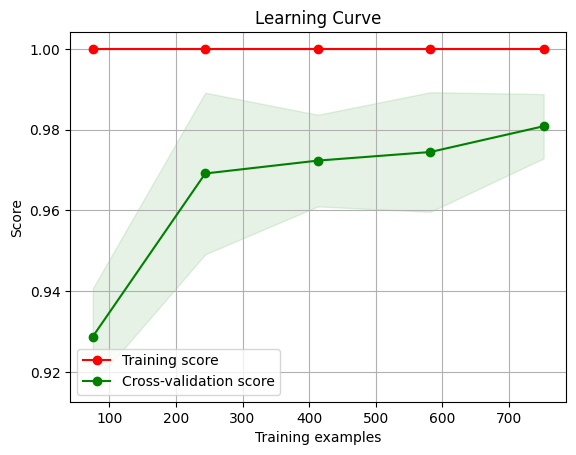

In [ ]:
# Función para graficar la curva de aprendizaje
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Llamar a la función para graficar la curva de aprendizaje del Random Forest
plot_learning_curve(best_rf_model, "Learning Curve", X_train, y_train, cv=5, n_jobs=-1)

plt.show()

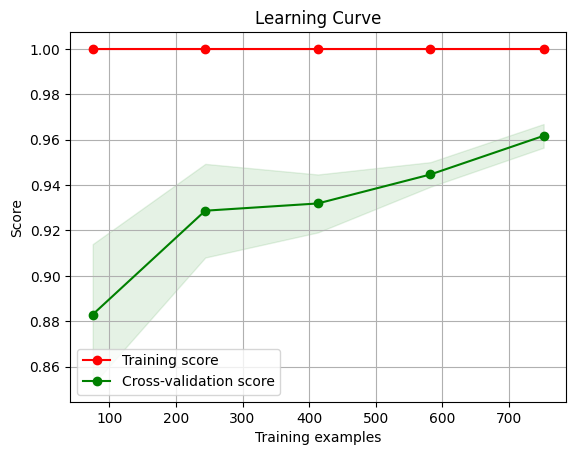

In [ ]:
# Llamar a la función para graficar la curva de aprendizaje del SVM
plot_learning_curve(best_svm_model, "Learning Curve", X_train, y_train, cv=5, n_jobs=-1)

plt.show()

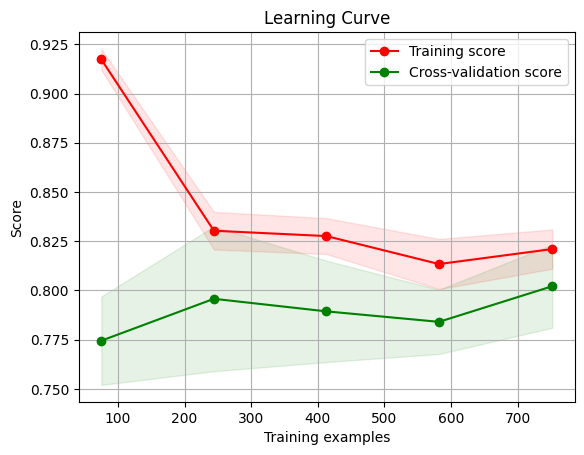

In [ ]:
# Llamar a la función para graficar la curva de aprendizaje de la Regresión Logística
plot_learning_curve(rl, "Learning Curve", X_train, y_train, cv=5, n_jobs=-1)

plt.show()

Efectivamente, tanto los resultados del Random Forest como del SVM se deben a un sobreajuste de los datos. En cambio, el modelo de Regresión Logística muestra una mejor capacidad de aprendizaje de los datos.